In [19]:
# 시각화 시, 한글 깨짐 문제 해결 - 나눔폰트 설치 후, 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.chdir("/content/drive/MyDrive/암빅데이터_경진대회/최종코드")

## 폐암 데이터

### [1] Train-set, Test-set 비율 재설정

In [4]:
lung_train = pd.read_csv("./data/original/학습데이터_폐암.csv")
lung_train

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,72,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,99,2,142.0,68.2,87,102,99,1,0,0,0,157
1,1,66,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,99,2,179.4,61.1,54,112,99,0,1,0,0,567
2,2,75,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,169.8,73.8,79,73,99,0,1,0,0,253
3,3,77,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,1,1,1,0,1,2,2,158.5,79.1,78,137,1,0,0,0,0,266
4,4,85,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,2,172.3,44.3,48,85,99,1,0,1,0,470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,69,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,99,1,161.5,70.4,70,105,0,0,1,0,1,522
9996,9996,37,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,2,1,165.7,85.0,79,129,0,1,1,0,0,107
9997,9997,31,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,151.5,61.3,69,123,99,0,0,1,0,66
9998,9998,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,159.5,54.3,84,68,1,1,1,0,0,156


In [6]:
lung_test = pd.read_csv("./data/original/폐암 합성데이터.csv")
lung_test

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,0,35,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,174.2,69.1,82,43,0,0,1,0,0,355
1,1,60,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,1,0,0,0,3,0,158.8,67.4,52,86,0,0,0,1,0,166
2,2,45,1,1,1,1,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,159.7,71.2,49,68,99,1,1,1,1,623
3,3,31,0,0,0,1,0,0,0,1,1,1,0,1,0,0,1,0,0,1,1,1,99,1,153.6,71.0,82,87,1,1,0,0,0,445
4,4,55,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,99,1,163.6,72.0,68,127,99,0,1,0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,47,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,99,0,147.6,79.0,40,79,99,1,0,0,0,104
4996,4996,44,1,0,1,0,0,1,1,1,1,0,1,0,1,1,0,0,0,0,1,0,99,2,151.0,41.6,69,67,99,0,0,0,0,42
4997,4997,80,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,157.8,58.2,40,137,0,1,1,0,0,190
4998,4998,69,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,2,2,167.5,56.7,89,77,0,1,1,1,0,635


In [7]:
# train, test 모두 합쳐서 하나로 만든 뒤, 8:2나 9:1로 분할 (sklearn.train_test_split 사용)
# 모델링 방법이 10-fold CV가 가능하다면 진행

# concatenate train + test
lung_total = pd.concat([lung_train,lung_test], ignore_index=True)

# 새로 Train, Test 나눠주기 전에 전체 데이터 shuffle 진행
lung_shuffle = lung_total.sample(frac=1, random_state=23).reset_index(drop=True)
lung_shuffle

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy,Death,Survival period
0,2142,42,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,2,0,166.4,69.0,51,68,99,1,0,0,1,383
1,6922,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,152.9,62.6,31,58,99,1,0,1,0,592
2,5602,44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,99,1,173.1,78.8,68,111,99,1,1,0,0,596
3,9624,67,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,2,166.9,80.1,90,94,99,1,1,0,0,300
4,599,59,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,99,2,147.2,71.3,80,107,99,1,0,1,0,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1190,50,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,99,2,180.3,79.6,48,80,99,1,1,0,1,350
14996,185,35,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,0,3,1,148.3,55.7,65,115,0,1,0,0,0,408
14997,9256,59,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,99,0,155.1,66.4,54,46,99,1,0,0,0,379
14998,3030,82,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,99,0,171.7,62.2,61,140,99,0,0,0,1,254


In [8]:
lung_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No                       15000 non-null  int64  
 1   AGE                      15000 non-null  int64  
 2   Adenocarcinoma           15000 non-null  int64  
 3   Large cell carcinoma     15000 non-null  int64  
 4   Squamous cell carcinoma  15000 non-null  int64  
 5   TX                       15000 non-null  int64  
 6   T0                       15000 non-null  int64  
 7   T1                       15000 non-null  int64  
 8   T1a                      15000 non-null  int64  
 9   T1b                      15000 non-null  int64  
 10  T1c                      15000 non-null  int64  
 11  T2                       15000 non-null  int64  
 12  T2a                      15000 non-null  int64  
 13  T2b                      15000 non-null  int64  
 14  T3                    

In [9]:
# X,y 설정
# y값 : Death, Survival period 컬럼
lung_y = lung_shuffle.iloc[:,32:34]          # DataFrame
lung_death = lung_shuffle.iloc[:,32]         # Series
lung_survival = lung_shuffle.iloc[:,33]      # Series


# x값: Death, Survival period를 제외한 모든 컬럼
lung_x = lung_shuffle.drop(['Death','Survival period'],axis=1,inplace=False)      # DataFrame

In [10]:
# Train, Test로 분할 - train_test_split 사용
## Shuffle은 이미 해주었기 때문에 False로 설정
## Train과 Test에서 Death의 비율이 비슷하도록 하기 위해 stratify 기준을 Death로 설정
x_train, x_test, y_train, y_test = train_test_split(lung_x, lung_y, test_size=0.1, shuffle=True, stratify=lung_y['Death'], random_state=23)

In [11]:
print("x_train의 shape : ",x_train.shape)
print("y_train의 shape : ",y_train.shape)
print("x_test의 shape : ",x_test.shape)
print("y_test의 shape : ",y_test.shape)

x_train의 shape :  (13500, 32)
y_train의 shape :  (13500, 2)
x_test의 shape :  (1500, 32)
y_test의 shape :  (1500, 2)


In [12]:
print("<y_train에서 Death 0/1 분포> \n", y_train['Death'].value_counts(),"\n")
print("<y_test에서 Death 0/1 분포> \n" , y_test['Death'].value_counts())
## Train과 Test에서 Death 비율 비슷하게 분배됨.
## 0:아니오, 1:예
## 생존:사망의 비율이 대략 3:1임.

<y_train에서 Death 0/1 분포> 
 0    9887
1    3613
Name: Death, dtype: int64 

<y_test에서 Death 0/1 분포> 
 0    1099
1     401
Name: Death, dtype: int64


In [13]:
x_train 
## shuffle을 2번 수행하여 No와 index 모두 섞여있음

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy
9133,8081,59,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,2,166.1,59.5,80,93,99,0,1,0
14043,2779,49,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,156.1,68.1,31,114,0,0,0,1
5156,3790,72,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,2,174.0,52.7,81,148,0,0,0,0
462,6722,63,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,99,2,170.8,52.5,39,107,99,1,0,0
3897,3854,51,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,1,152.1,45.3,42,54,99,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,3550,47,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,156.4,59.5,80,75,99,0,0,0
12410,648,47,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,3,2,174.3,51.8,71,65,0,1,0,0
11508,6060,78,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,2,0,169.0,43.8,70,68,99,0,0,1
3852,1636,74,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,171.9,56.2,38,116,99,1,1,0


In [14]:
# index 번호 0부터 순서대로 reset.
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [15]:
x_train

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy
0,8081,59,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,2,166.1,59.5,80,93,99,0,1,0
1,2779,49,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,156.1,68.1,31,114,0,0,0,1
2,3790,72,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,2,174.0,52.7,81,148,0,0,0,0
3,6722,63,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,99,2,170.8,52.5,39,107,99,1,0,0
4,3854,51,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,1,152.1,45.3,42,54,99,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13495,3550,47,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,156.4,59.5,80,75,99,0,0,0
13496,648,47,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,3,2,174.3,51.8,71,65,0,1,0,0
13497,6060,78,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,2,0,169.0,43.8,70,68,99,0,0,1
13498,1636,74,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,171.9,56.2,38,116,99,1,1,0


In [16]:
lung_x['BMI']=lung_x['Weight']/(lung_x['Height']**2)
lung_x

,No,AGE,Adenocarcinoma,Large cell carcinoma,Squamous cell carcinoma,TX,T0,T1,T1a,T1b,T1c,T2,T2a,T2b,T3,T4,N1,N2,N3,M1a,M1b,M1c,Type of Drink,Smoke,Height,Weight,FEV1_FVC_P,DLCO_VA_P,EGFR mutation Detection,Operation,Chemotherapy,Radiation Therapy,BMI
0,2142,42,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,2,0,166.4,69.0,51,68,99,1,0,0,0.002492
1,6922,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,152.9,62.6,31,58,99,1,0,1,0.002678
2,5602,44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,99,1,173.1,78.8,68,111,99,1,1,0,0.002630
3,9624,67,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,2,166.9,80.1,90,94,99,1,1,0,0.002876
4,599,59,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,99,2,147.2,71.3,80,107,99,1,0,1,0.003291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1190,50,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,99,2,180.3,79.6,48,80,99,1,1,0,0.002449
14996,185,35,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,1,0,0,3,1,148.3,55.7,65,115,0,1,0,0,0.002533
14997,9256,59,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,99,0,155.1,66.4,54,46,99,1,0,0,0.002760
14998,3030,82,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,99,0,171.7,62.2,61,140,99,0,0,0,0.002110


### [2] 연구가설 설정  및 검증

### 공통-가설1) 음주와 흡연을 할수록  
 * 사망여부가 1인경우가 더 많을 것.  
 * '암진단후생존일수'가 더 짧을 것.  

In [17]:
df_smk_drk = pd.DataFrame()
df_smk_drk['DRINK'] = lung_x['Type of Drink'].map({1:"맥주",2:"소주",3:"양주",99:"기타"})
df_smk_drk['SMOKE'] = lung_x['Smoke'].map({0:"비흡연",1:"현재흡연",2:"과거흡연"})
df_smk_drk['SURVIVE'] = lung_death.map({0:"SURVIVED", 1:"DEAD"})
df_smk_drk['PERIOD'] = lung_survival
df_smk_drk

,DRINK,SMOKE,SURVIVE,PERIOD
0,소주,비흡연,DEAD,383
1,소주,과거흡연,SURVIVED,592
2,기타,현재흡연,SURVIVED,596
3,소주,과거흡연,SURVIVED,300
4,기타,과거흡연,SURVIVED,253
...,...,...,...,...
14995,기타,과거흡연,DEAD,350
14996,양주,현재흡연,SURVIVED,408
14997,기타,비흡연,SURVIVED,379
14998,기타,비흡연,DEAD,254


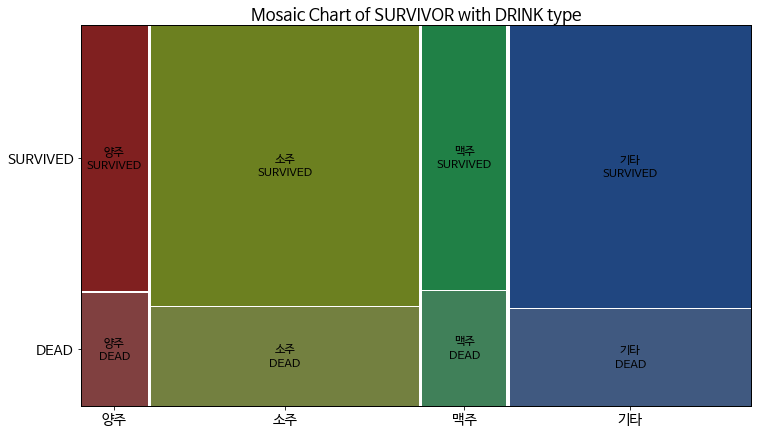

In [20]:
import warnings
warnings.filterwarnings(action='ignore')

## Type of Drink(Categorical) - Death(Categorical) : Mosaic plot
mosaic(df_smk_drk.sort_values('DRINK',ascending=False),['DRINK','SURVIVE'],
       title = 'Mosaic Chart of SURVIVOR with DRINK type')
plt.show()
plt.rcParams['figure.figsize'] = [15, 8]
plt.rc('font',family = 'NanumBarunGothic', size=14)

## 알 수 있는 점
## 주류 도수가 높다고 해서 DEAD비율이 높아지지는 않음.

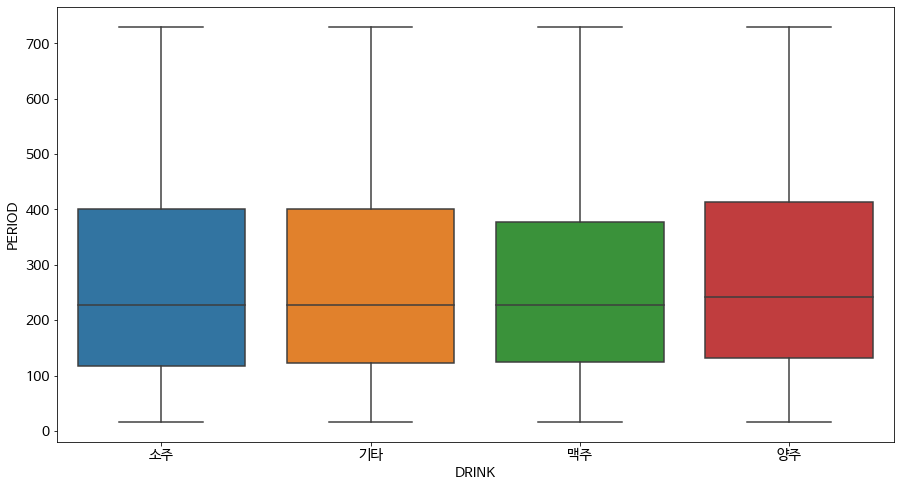

In [21]:
## Type of Drink(Categorical) - Survival Period(Numeric)
sns.boxplot(x="DRINK",
            y="PERIOD",
            data=df_smk_drk)
## 알 수 있는 점
## 음주 종류에 따라 Survival period에 큰 차이가 없는 것으로 보임.

In [22]:
df_smk_drk['SMOKE'].value_counts()

과거흡연    9033
비흡연     3729
현재흡연    2238
Name: SMOKE, dtype: int64

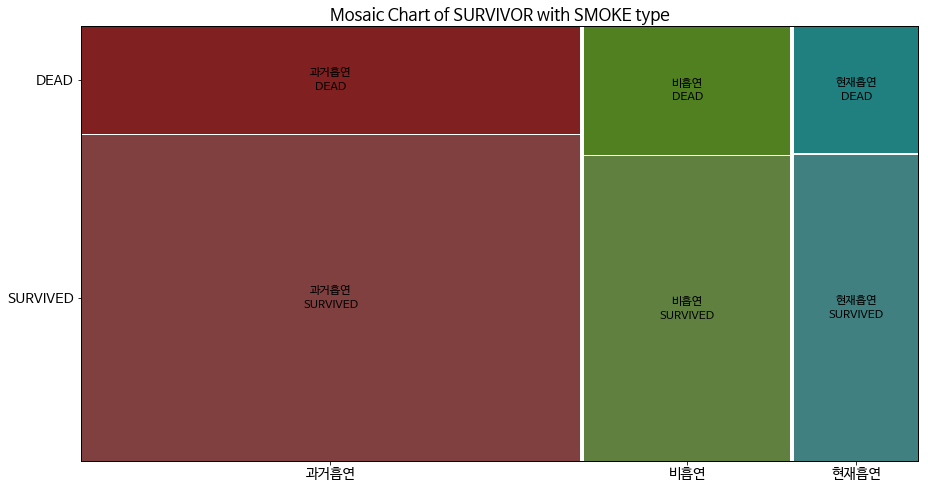

In [23]:
import warnings
warnings.filterwarnings(action='ignore')

## Smoke(Categorical) - Death(Categorical) : Mosaic plot
mosaic(df_smk_drk.sort_values('SMOKE'),['SMOKE','SURVIVE'],
       title = 'Mosaic Chart of SURVIVOR with SMOKE type')
plt.show()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font',family = 'NanumBarunGothic', size=14)

## 알 수 있는 점
## 과거흡연, 비흡연, 현재흡연 순으로 DEAD 비율이 높음
## 비흡연자의 DEAD 비율이 현재흡연자의 DEAD 비율보다 높기 때문에 현재흡연과 사망 여부는 크게 관련이 있어보이지 않음.

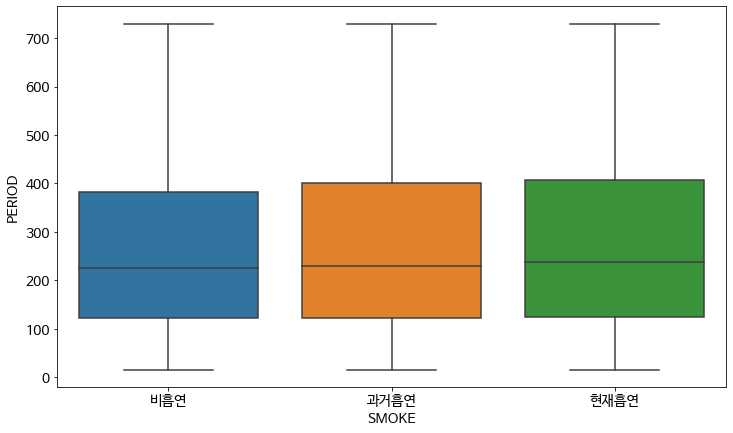

In [24]:
## Smoke (Categorical) - Survival Period(Numeric)
sns.boxplot(x="SMOKE",
            y="PERIOD",
            data=df_smk_drk)
## 알 수 있는 점
## 과거흡연의 경우 다른 경우에 비해 생존 기간의 Q2값이 더 작고, Q1~Q3 구간이 더 작은 쪽에 위치함.
# 비흡연, 현재 흡연은 큰 차이가 없음.

### 공통-가설2) BMI(체질량지수=w/t^2 , w:몸무게(kg), t:키(m) )가 클수록 
* 사망인 경우가 많을 것이다.
*'암진단후생존일수’가 짧을 것이다.

In [25]:
lung_bmi=pd.DataFrame()
lung_bmi['BMI']=lung_x['BMI']
lung_bmi['SURVIVED']=lung_y['Death']
lung_bmi['PERIOD']=lung_y['Survival period']
lung_bmi

,BMI,SURVIVED,PERIOD
0,0.002492,1,383
1,0.002678,0,592
2,0.002630,0,596
3,0.002876,0,300
4,0.003291,0,253
...,...,...,...
14995,0.002449,1,350
14996,0.002533,0,408
14997,0.002760,0,379
14998,0.002110,1,254


In [26]:
lung_bmi['BMI']=np.digitize(lung_bmi['BMI'],bins=[0.0023,0.0025,0.0030,0.0035])
lung_bmi['BMI']=lung_bmi['BMI'].map({0:"정상",1:"과체중",2:"비만 1단계", 3:"비만 2단계",4:"비만 3단계"})
lung_bmi['SURVIVED']=lung_bmi['SURVIVED'].map({0:"SURVIVED",1:"DEAD"})

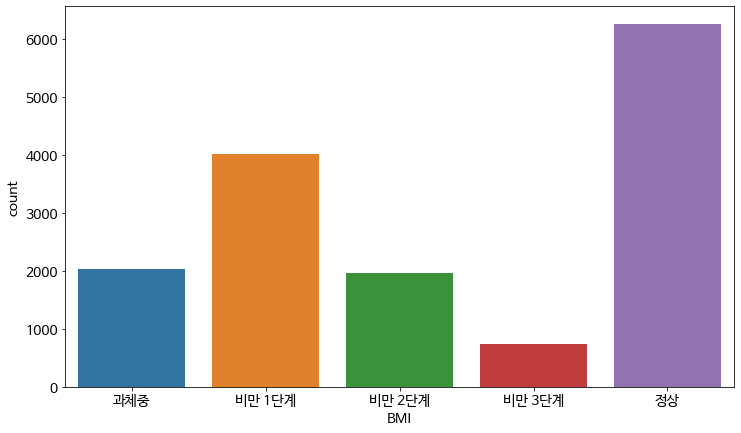

In [27]:
sns.countplot(data=lung_bmi.sort_values('BMI'),x='BMI')
plt.show()

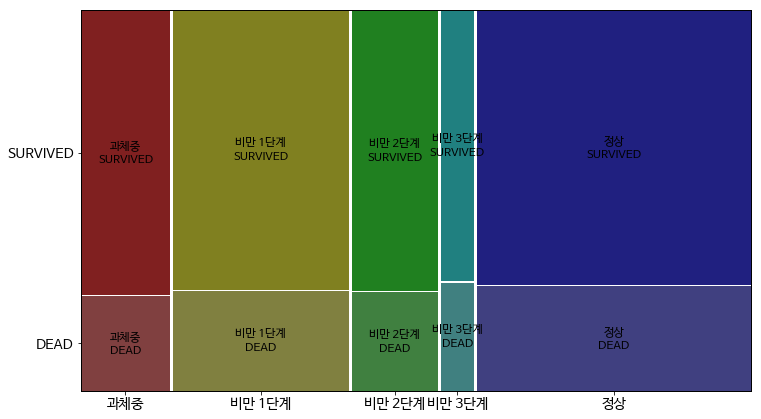

In [28]:
mosaic(lung_bmi.sort_values('BMI'),['BMI','SURVIVED'])
plt.show()

#비만 초기 단계에서 후기 단계로 갈수록 사망률이 줄어듬.

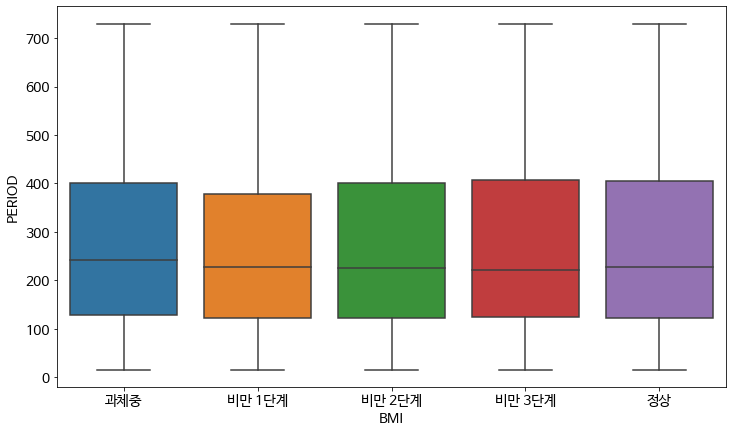

In [29]:
sns.boxplot(data=lung_bmi.sort_values('BMI'),x='BMI',y='PERIOD')

#비만 3단계에서 가장 오랜 생존 기간을 보임.

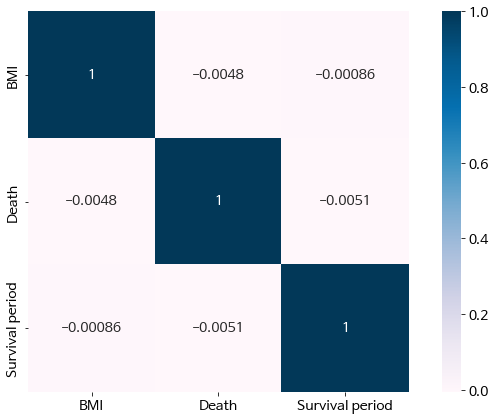

In [30]:
#BMI와 Death, Survival period 간의 상관계수
colormap=plt.cm.PuBu
heatmap_bmi=pd.concat([lung_x['BMI'],lung_death,lung_survival],axis=1)
sns.heatmap(data=heatmap_bmi.corr(),annot=True, square=True,cmap=colormap)

In [31]:
#상관계수 검정
corr_bmi1=stats.pearsonr(lung_x['BMI'],lung_death)
corr_bmi2=stats.pearsonr(lung_x['BMI'],lung_survival)
print("bmi와 사망률 사이의 p-value:",corr_bmi1)
print("bmi와 생존 기간 사이의 p-value:",corr_bmi2)

#알파=0.05
#모든 p-value가 0.05보다 크므로 변수 간의 유의미한 상관관계를 갖는다고 할 수 없다.

bmi와 사망률 사이의 p-value: (-0.00484256059403409, 0.553151588433735)
bmi와 생존 기간 사이의 p-value: (-0.0008576444472000594, 0.9163513456080014)


### 가설3) EGFR mutation Detection이 1일 때, 
* 생존인 경우가 많을 것이다.

* ‘암진단후생존일수’가 길 것이다.

In [32]:
df_egfr = pd.DataFrame()
df_egfr['EGFR'] = lung_x['EGFR mutation Detection'].map({0:"발견 X",1:"발견",99:"기타"})

df_egfr['SURVIVE'] = lung_death.map({0:"SURVIVED", 1:"DEAD"})
df_egfr['PERIOD'] = lung_survival
df_egfr

,EGFR,SURVIVE,PERIOD
0,기타,DEAD,383
1,기타,SURVIVED,592
2,기타,SURVIVED,596
3,기타,SURVIVED,300
4,기타,SURVIVED,253
...,...,...,...
14995,기타,DEAD,350
14996,발견 X,SURVIVED,408
14997,기타,SURVIVED,379
14998,기타,DEAD,254


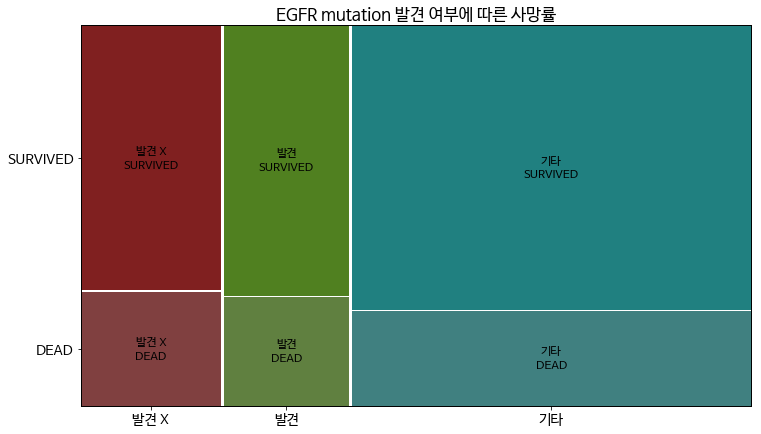

In [33]:
mosaic(df_egfr.sort_values('EGFR',ascending=False),['EGFR','SURVIVE'],
       title = 'EGFR mutation 발견 여부에 따른 사망률')
plt.show()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font',family = 'NanumBarunGothic', size=14)

#EGFR mutation이 1일 때(발견되었을 때), DEAD의 비율이 낮다.

### 가설4) FEV, DLCO 검사 값에 따라 수술방법과 치료방법이 달라질 것이다.

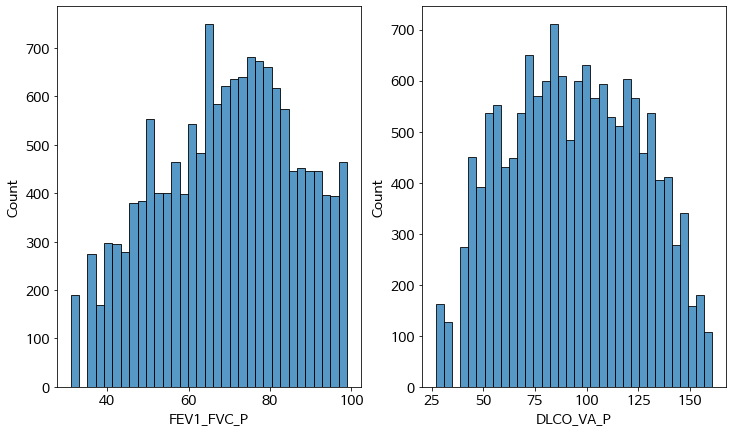

In [34]:
plt.subplot(1,2,1)
sns.histplot(data=lung_x['FEV1_FVC_P'])

plt.subplot(1,2,2)
sns.histplot(data=lung_x['DLCO_VA_P'])
plt.show()

In [35]:
lung_fev1=pd.DataFrame()
lung_fev1['FEV1']=lung_x['FEV1_FVC_P']
lung_fev1['SURVIVED']=lung_death
lung_fev1['PERIOD']=lung_survival
lung_fev1

,FEV1,SURVIVED,PERIOD
0,51,1,383
1,31,0,592
2,68,0,596
3,90,0,300
4,80,0,253
...,...,...,...
14995,48,1,350
14996,65,0,408
14997,54,0,379
14998,61,1,254


In [36]:
lung_operation=pd.DataFrame()
lung_operation=lung_x.loc[lung_x['Operation']==1]

In [37]:
lung_operation=lung_operation.iloc[:,26:]
lung_operation.drop('EGFR mutation Detection',axis=1,inplace=True)

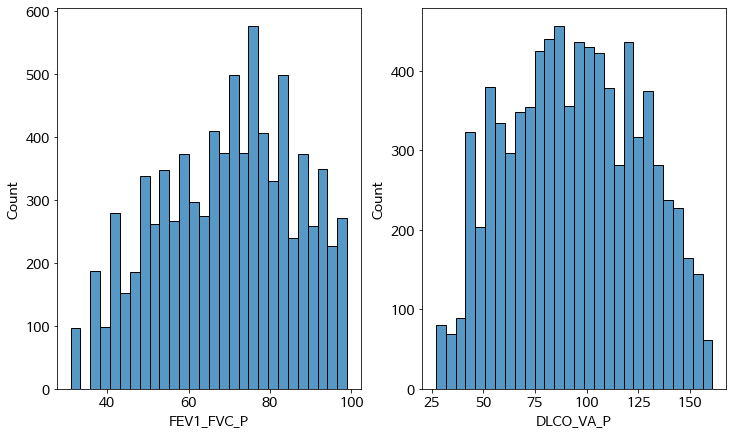

In [38]:
#operation이 1일 때 FEV와 DLCO 값의 분포
plt.subplot(1,2,1)
sns.histplot(data=lung_operation['FEV1_FVC_P'])

plt.subplot(1,2,2)
sns.histplot(data=lung_operation['DLCO_VA_P'])
plt.show()

#FEV와 DLCO 값이 특정 범위에 몰려있지 않고 전체적으로 분포되어 있음.
#FEV와 DLCO 값에 따라 operation이 달라지지 않음.

In [39]:
lung_chemotheraphy=pd.DataFrame()
lung_chemotheraphy=lung_x.loc[lung_x['Chemotherapy']==1]

In [40]:
lung_chemotheraphy=lung_chemotheraphy.iloc[:,26:]
lung_chemotheraphy.drop('EGFR mutation Detection',axis=1,inplace=True)

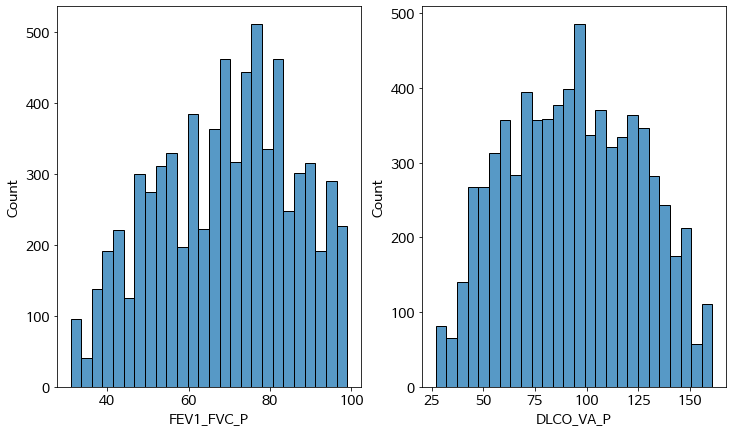

In [41]:
#chemotheraphy가 1일 때 FEV와 DLCO 값의 분포
plt.subplot(1,2,1)
sns.histplot(data=lung_chemotheraphy['FEV1_FVC_P'])

plt.subplot(1,2,2)
sns.histplot(data=lung_chemotheraphy['DLCO_VA_P'])
plt.show()

#FEV와 DLCO 값이 특정 범위에 몰려있지 않고 전체적으로 분포되어 있음.
#FEV와 DLCO 값에 따라 chemotheraphy가 달라지지 않음.

In [42]:
lung_radiation=pd.DataFrame()
lung_radiation=lung_x.loc[lung_x['Radiation Therapy']==1]
lung_radiation=lung_radiation.iloc[:,26:]
lung_radiation.drop('EGFR mutation Detection',axis=1,inplace=True)

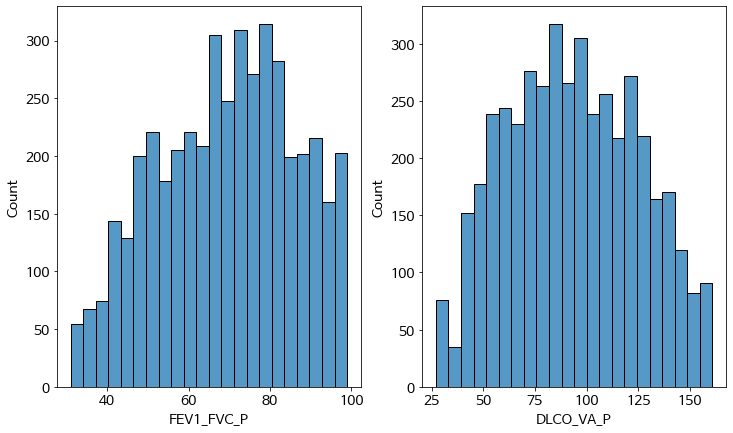

In [43]:
#radiation therapy가 1일 때 FEV와 DLCO 값의 분포
plt.subplot(1,2,1)
sns.histplot(data=lung_radiation['FEV1_FVC_P'])

plt.subplot(1,2,2)
sns.histplot(data=lung_radiation['DLCO_VA_P'])
plt.show()

#FEV와 DLCO 값이 특정 범위에 몰려있지 않고 전체적으로 분포되어 있음.
#FEV와 DLCO 값에 따라 radiation therapy가 달라지지 않음.